In [ ]:
# Menyiapkan library
import tensorflow as tf
import os
from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import urllib
import matplotlib.pyplot as plt
! pip install -q kaggle
from google.colab import files
files.upload()

In [2]:
# Untuk mengambil data dari kaggle
! mkdir ~/.kaggle
! mv ./kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d puneet6060/intel-image-classification
! unzip \*.zip  && rm *.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain

In [12]:
# Preprocessing Data
TRAINING_DIR = '/content/seg_train/seg_train/'
training_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    )

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR, 
    class_mode='categorical', 
    target_size=(150, 150), 
    seed=42
)

VALIDATION_DIR = '/content/seg_test/seg_test/'

validation_datagen = ImageDataGenerator(
    rescale=1./255,        
)

validation_generator = validation_datagen.flow_from_directory(      
    VALIDATION_DIR,    
    class_mode='categorical',
    target_size=(150, 150),
    seed=42
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
tf.keras.backend.clear_session()

# Untuk callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy')>0.92 and (logs.get('val_accuracy') > 0.92):
            print('Acc and Val Acc sudah mencapai 92%...')
            self.model.stop_training = True

# load model
model_mob = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3),
                                              include_top=False,
                                              weights='imagenet')

for layer in model_mob.layers:
	layer.trainable = False

model_mob_ = tf.keras.Sequential([
                          model_mob,
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                          tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                          tf.keras.layers.Dropout(.2),
                          tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                          tf.keras.layers.Dropout(.2),
                          tf.keras.layers.Dense(6, activation='softmax')])

# model_mob_.summary()

model_mob_.compile(
              # optimizer=tf.keras.optimizers.Adam(0.00001), 
              optimizer=tf.keras.optimizers.RMSprop(0.00001),
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [20]:
history = model_mob_.fit(
                train_generator,                
                validation_data = validation_generator,
                epochs = 50,
                verbose = 1,    
                callbacks=[myCallback()]
            )

Epoch 1/50
439/439 [==============================] - 83s 189ms/step - loss: 2.1514 - accuracy: 0.9791 - val_loss: 2.2937 - val_accuracy: 0.9133
Epoch 2/50
439/439 [==============================] - 84s 190ms/step - loss: 1.9398 - accuracy: 0.9797 - val_loss: 2.0982 - val_accuracy: 0.9157
Epoch 3/50
439/439 [==============================] - 83s 188ms/step - loss: 1.7561 - accuracy: 0.9823 - val_loss: 1.9373 - val_accuracy: 0.9090
Epoch 4/50
439/439 [==============================] - 81s 185ms/step - loss: 1.5864 - accuracy: 0.9818 - val_loss: 1.7748 - val_accuracy: 0.9167
Epoch 5/50
439/439 [==============================] - 83s 189ms/step - loss: 1.4391 - accuracy: 0.9836 - val_loss: 1.6299 - val_accuracy: 0.9187
Epoch 6/50
439/439 [==============================] - 81s 185ms/step - loss: 1.3121 - accuracy: 0.9835 - val_loss: 1.5271 - val_accuracy: 0.9167
Epoch 7/50
439/439 [==============================] - 81s 185ms/step - loss: 1.2072 - accuracy: 0.9820 - val_loss: 1.4185 - val_ac

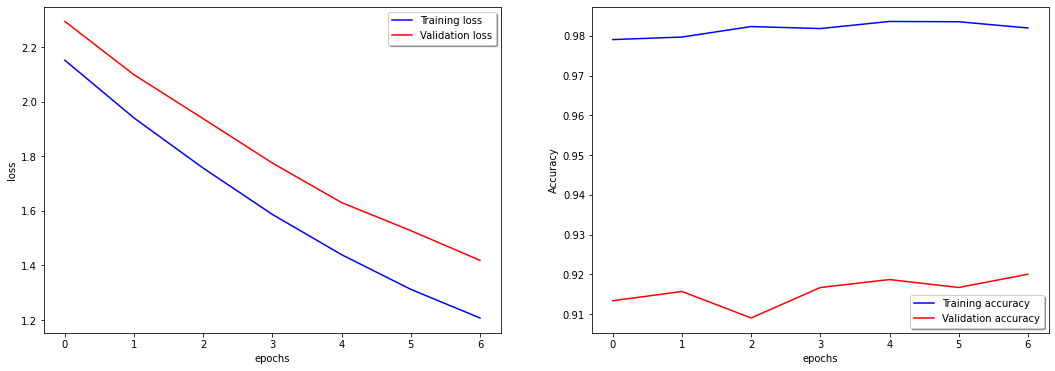

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')    
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='best', shadow=True)

In [22]:
# Save Model
import pathlib
export_dir = '/content/'
tf.saved_model.save(model_mob_, export_dir)

# Convert model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('model_TL_CNN.tflite')
tflite_model_file.write_bytes(tflite_model)

# Download model
try:
    from google.colab import files
    files.download(tflite_model_file)
except:
    pass

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /content/assets


INFO:tensorflow:Assets written to: /content/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>